In [2]:
# Cell 1: Imports and Setup
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import seaborn as sns
import pandas as pd
import json

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
cur_dir = os.getcwd()

Using device: cpu


In [3]:
# Cell 2: Data Loading and Preprocessing
class GTSRBDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = pd.read_csv(csv_file)
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data.iloc[idx]['Path'])
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx]['ClassId']
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

with open("config.json", "r") as f:
    config = json.load(f)

root_dir = config["dataset_path"]
csv_file = os.path.join(root_dir, "Train.csv")

train_dataset = GTSRBDataset(
    root_dir=root_dir,
    csv_file=csv_file,
    transform=train_transform
)

# Split dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


        

In [4]:
# Cell 3: CNN Architecture
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=43): #GTSRB has 43 classes
        super(TrafficSignCNN, self).__init__()
        self.features = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Initialize model
model = TrafficSignCNN().to(device)



In [5]:
# Cell 4: Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [8]:
# Cell 5: Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
    
        # Validation phase
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    return train_losses, val_accuracies

# Train the model
train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)







Epoch 1/20, Loss: 1.9870, Val Accuracy: 68.29%
Epoch 2/20, Loss: 0.6873, Val Accuracy: 88.82%
Epoch 3/20, Loss: 0.3664, Val Accuracy: 94.25%
Epoch 4/20, Loss: 0.2520, Val Accuracy: 95.80%
Epoch 5/20, Loss: 0.1941, Val Accuracy: 96.60%
Epoch 6/20, Loss: 0.1620, Val Accuracy: 95.94%
Epoch 7/20, Loss: 0.1358, Val Accuracy: 97.74%
Epoch 8/20, Loss: 0.1210, Val Accuracy: 97.77%
Epoch 9/20, Loss: 0.1126, Val Accuracy: 97.19%
Epoch 10/20, Loss: 0.1056, Val Accuracy: 97.39%
Epoch 11/20, Loss: 0.0979, Val Accuracy: 97.56%
Epoch 12/20, Loss: 0.0891, Val Accuracy: 97.90%
Epoch 13/20, Loss: 0.0942, Val Accuracy: 98.21%
Epoch 14/20, Loss: 0.0835, Val Accuracy: 98.30%
Epoch 15/20, Loss: 0.0768, Val Accuracy: 97.78%
Epoch 16/20, Loss: 0.0820, Val Accuracy: 98.29%
Epoch 17/20, Loss: 0.0771, Val Accuracy: 98.39%
Epoch 18/20, Loss: 0.0729, Val Accuracy: 97.58%
Epoch 19/20, Loss: 0.0742, Val Accuracy: 98.50%
Epoch 20/20, Loss: 0.0672, Val Accuracy: 98.29%


In [9]:
# file path to results directory
results_dir = config["results_path"]

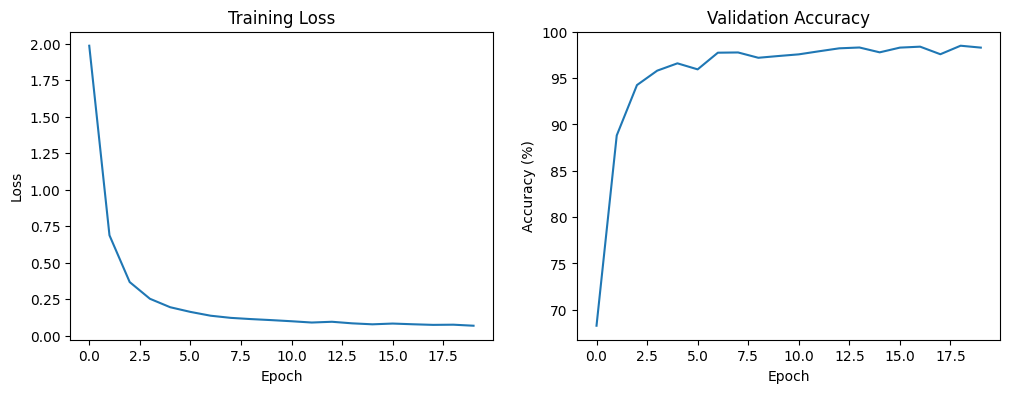

In [10]:
# Cell 6: Plotting Results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.savefig(results_dir + '/training_curves.png', dpi=300, bbox_inches='tight')


In [15]:
# Cell 7: Simple UI for Testing
def predict_image(image_path, model):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = test_transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
    
    return predicted.item()


# Save the model
model_dir = config["model_path"]
torch.save(model.state_dict(), model_dir + '/02_traffic_sign_classifier.pth')


In [16]:
test_image_path = root_dir + '/Test/12629.png'
prediction = predict_image(test_image_path, model)
print(f"Predicted class: {prediction}")

Predicted class: 10


In [17]:
# Reload your saved model
def load_saved_model(model_file_path):
    # Initialize the model architecture
    model = TrafficSignCNN().to(device)
    
    # Load the saved weights
    model.load_state_dict(torch.load(model_file_path))
    
    # Set to evaluation mode
    model.eval()
    
    return model

# Load the saved model
model_file = os.path.join(model_dir, "02_traffic_sign_classifier.pth")
model = load_saved_model(model_file)

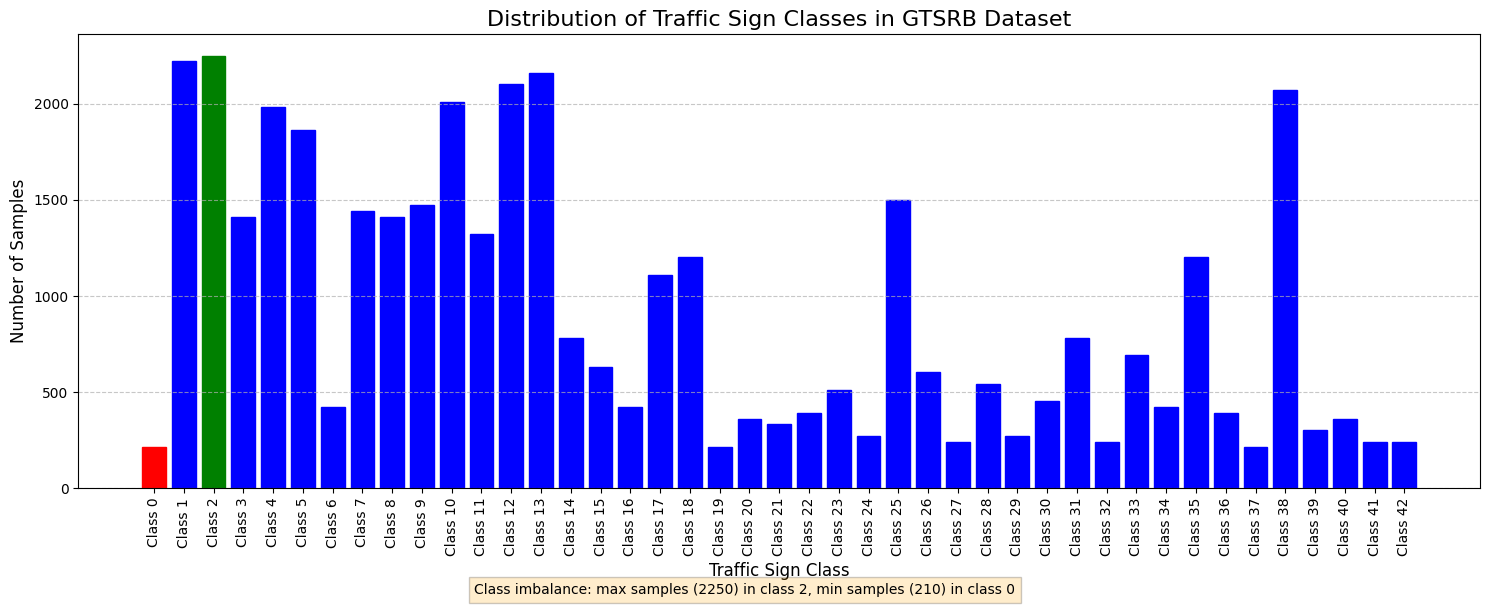

In [18]:
# Class distribution visualization
df = pd.read_csv(csv_file)  # Adjust path to your train CSV
# Count samples per class
class_distribution = df['ClassId'].value_counts().sort_index()
class_names = [f"Class {i}" for i in class_distribution.index]

plt.figure(figsize=(15, 6))
bars = plt.bar(class_names, class_distribution.values)

# Highlight the classes with most and least samples
max_class = class_distribution.idxmax()
min_class = class_distribution.idxmin()

# Colorize bars
for i, bar in enumerate(bars):
    if i == max_class:
        bar.set_color('green')
    elif i == min_class:
        bar.set_color('red')
    else:
        bar.set_color('blue')

plt.title('Distribution of Traffic Sign Classes in GTSRB Dataset', fontsize=16)
plt.xlabel('Traffic Sign Class', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add text explaining the imbalance
plt.figtext(0.5, 0.001, f"Class imbalance: max samples ({class_distribution.max()}) in class {max_class}, min samples ({class_distribution.min()}) in class {min_class}", 
            ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":4})

plt.tight_layout()
plt.savefig(results_dir + '/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

Top 5 most common misclassifications:
True class 1 predicted as class 2: 12 instances
True class 39 predicted as class 38: 11 instances
True class 3 predicted as class 5: 7 instances
True class 1 predicted as class 5: 5 instances
True class 5 predicted as class 2: 4 instances


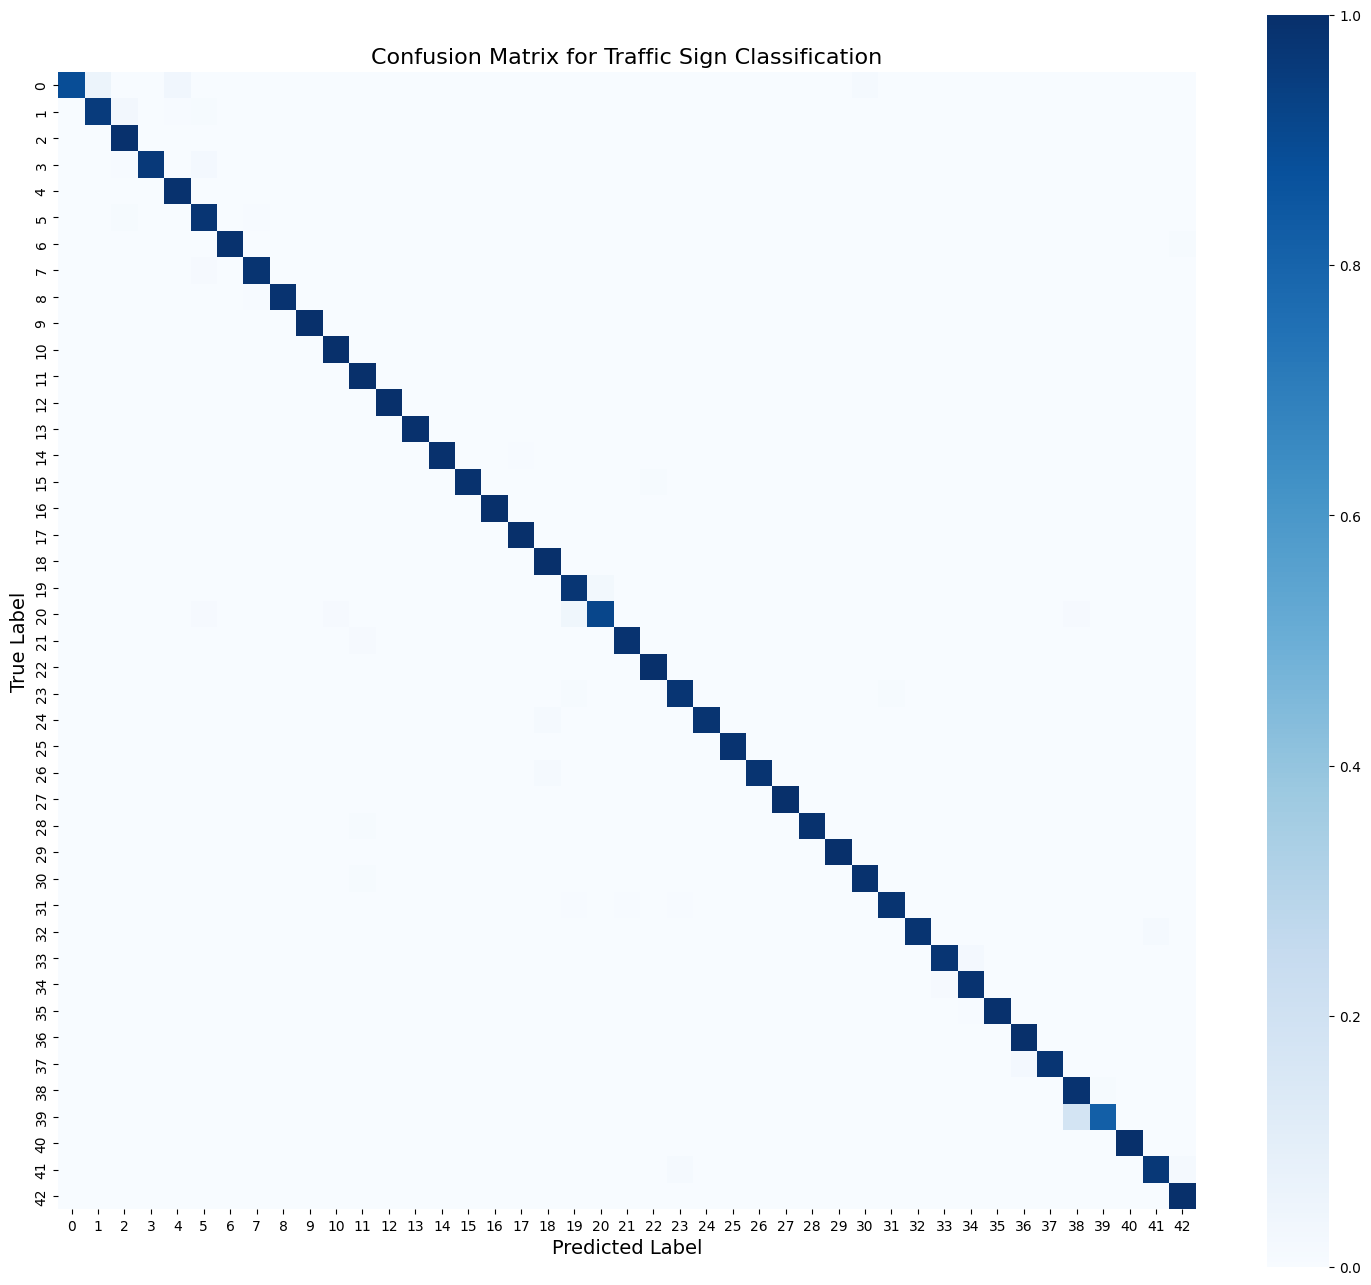

In [21]:
# Confusion matrix generation
# for use for classification examples
misclassifications = []

def generate_confusion_matrix(model, data_loader, num_classes=43):
    """
    Generate a confusion matrix for the trained model.
    
    Args:
        model: The trained PyTorch model
        data_loader: DataLoader containing validation or test data
        num_classes: Number of traffic sign classes
    """
    # Set model to evaluation mode
    model.eval()
    
    # Initialize lists to store predictions and ground truth
    all_preds = []
    all_labels = []
    
    # Disable gradient computation for inference
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 13))
    sns.heatmap(cm_normalized, annot=False, cmap='Blues', fmt='.2f', square=True)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.title('Confusion Matrix for Traffic Sign Classification', fontsize=16)
    
    
    plt.tight_layout()
    plt.savefig(results_dir + '/confusion_matrix.png', dpi=300, bbox_inches='tight')
    
    # Find the most common misclassifications
    misclassified = []
    for i in range(num_classes):
        for j in range(num_classes):
            if i != j and cm[i, j] > 0:
                misclassified.append((i, j, cm[i, j]))
    
    # Sort by count in descending order
    misclassified.sort(key=lambda x: x[2], reverse=True)
    
    # Print top 5 most common misclassifications
    print("Top 5 most common misclassifications:")
    for true_label, pred_label, count in misclassified[:5]:
        print(f"True class {true_label} predicted as class {pred_label}: {count} instances")
        misclassifications.append({'true': true_label, 'pred': pred_label})
    
    return cm


confusion_mat = generate_confusion_matrix(model, val_loader)

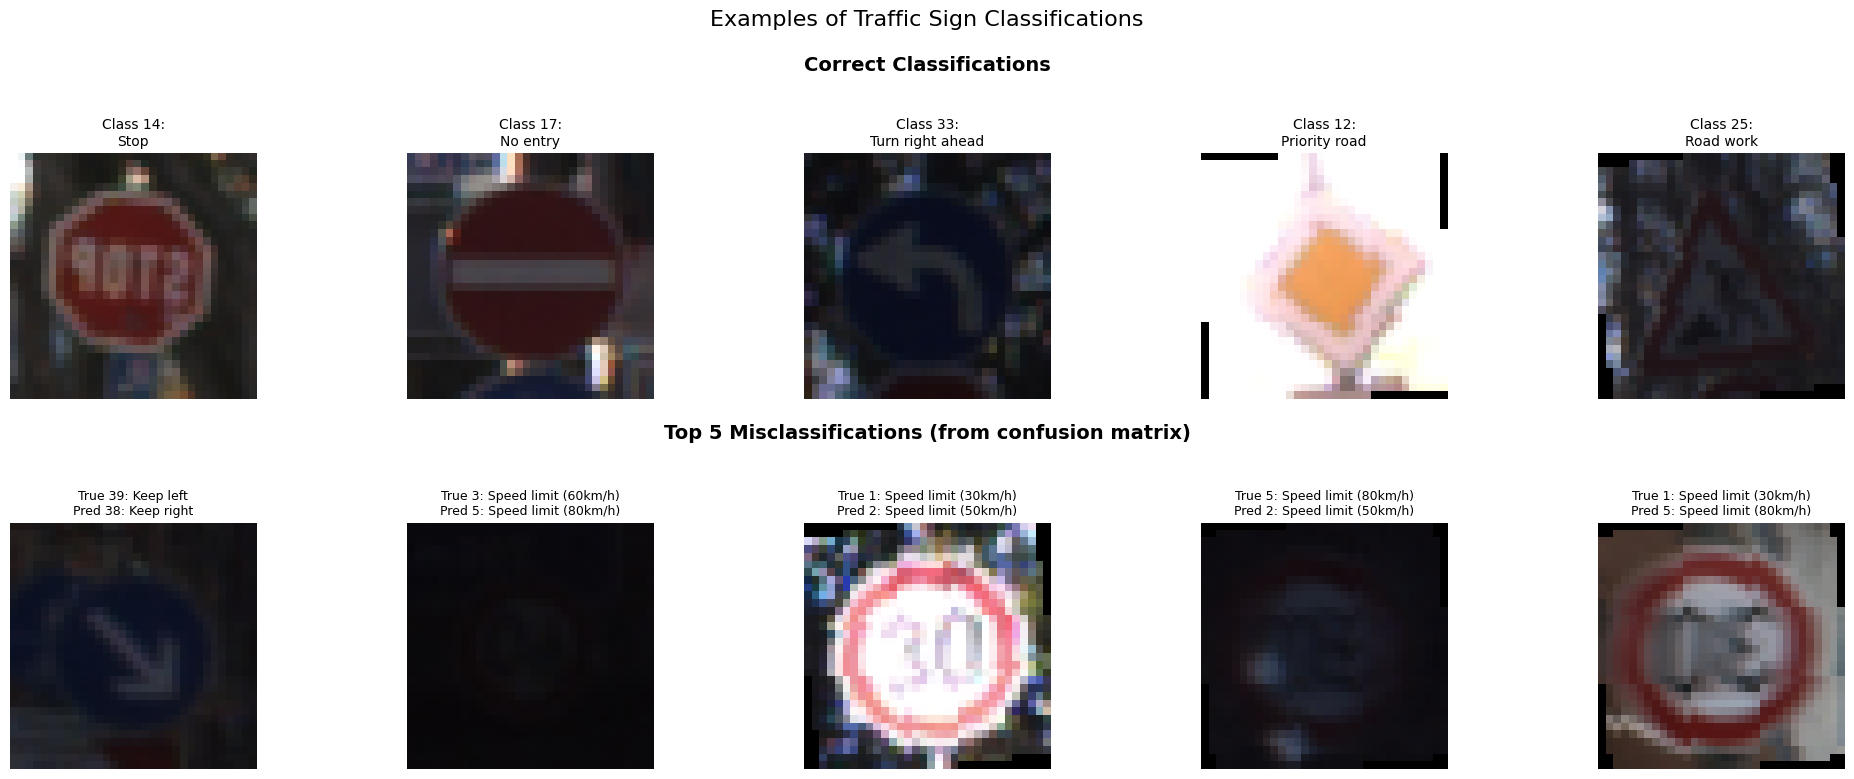

In [22]:
# Dictionary mapping class IDs to actual sign names for GTSRB dataset
sign_names = {
    0: 'Speed limit (20km/h)',
    1: 'Speed limit (30km/h)',
    2: 'Speed limit (50km/h)',
    3: 'Speed limit (60km/h)',
    4: 'Speed limit (70km/h)',
    5: 'Speed limit (80km/h)',
    6: 'End of speed limit (80km/h)',
    7: 'Speed limit (100km/h)',
    8: 'Speed limit (120km/h)',
    9: 'No passing',
    10: 'No passing for vehicles over 3.5 metric tons',
    11: 'Right-of-way at the next intersection',
    12: 'Priority road',
    13: 'Yield',
    14: 'Stop',
    15: 'No vehicles',
    16: 'Vehicles over 3.5 metric tons prohibited',
    17: 'No entry',
    18: 'General caution',
    19: 'Dangerous curve to the left',
    20: 'Dangerous curve to the right',
    21: 'Double curve',
    22: 'Bumpy road',
    23: 'Slippery road',
    24: 'Road narrows on the right',
    25: 'Road work',
    26: 'Traffic signals',
    27: 'Pedestrians',
    28: 'Children crossing',
    29: 'Bicycles crossing',
    30: 'Beware of ice/snow',
    31: 'Wild animals crossing',
    32: 'End of all speed and passing limits',
    33: 'Turn right ahead',
    34: 'Turn left ahead',
    35: 'Ahead only',
    36: 'Go straight or right',
    37: 'Go straight or left',
    38: 'Keep right',
    39: 'Keep left',
    40: 'Roundabout mandatory',
    41: 'End of no passing',
    42: 'End of no passing by vehicles over 3.5 metric tons'
}

def visualize_classifications(model, data_loader, save_path, num_correct=4, num_incorrect=4):
    """
    Visualize examples of correctly and incorrectly classified traffic signs.
    
    Args:
        model: Trained model
        data_loader: DataLoader containing validation or test data
        num_correct: Number of correctly classified examples to show
        num_incorrect: Number of incorrectly classified examples to show
        save_path: Path to save the visualization
    """
    model.eval()
    
    # From the confusion matrix analysis, target these specific misclassifications
    target_misclassifications = misclassifications
    
    # Pick diverse classes for correct examples (hand-picked for diversity)
    target_correct_classes = [14, 17, 33, 12, 25]  # Stop, No entry, Turn right, Priority road, Road work
    
    # Store found examples
    correct_examples = {class_id: None for class_id in target_correct_classes}
    incorrect_examples = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Look for specific correct classifications
            for i in range(len(inputs)):
                true_label = labels[i].item()
                pred_label = preds[i].item()
                
                # Check for correct examples of target classes
                if true_label in target_correct_classes and true_label == pred_label and correct_examples[true_label] is None:
                    img = inputs[i].cpu().numpy().transpose(1, 2, 0)
                    img = img * 0.5 + 0.5  # Denormalize
                    img = np.clip(img, 0, 1)
                    
                    correct_examples[true_label] = {
                        'image': img,
                        'true_label': true_label,
                        'pred_label': pred_label
                    }
                
                # Check for specific misclassifications from confusion matrix
                for target in target_misclassifications:
                    if true_label == target['true'] and pred_label == target['pred'] and not any(
                        e['true_label'] == true_label and e['pred_label'] == pred_label for e in incorrect_examples
                    ):
                        img = inputs[i].cpu().numpy().transpose(1, 2, 0)
                        img = img * 0.5 + 0.5  # Denormalize
                        img = np.clip(img, 0, 1)
                        
                        incorrect_examples.append({
                            'image': img,
                            'true_label': true_label,
                            'pred_label': pred_label
                        })
            
            # Check if we have all examples
            if all(ex is not None for ex in correct_examples.values()) and len(incorrect_examples) == len(target_misclassifications):
                break
    
    # Convert correct_examples dictionary to list
    correct_list = [ex for ex in correct_examples.values() if ex is not None]
    
    # Create the visualization
    num_correct = len(correct_list)
    num_incorrect = len(incorrect_examples)
    
    fig, axes = plt.subplots(2, max(num_correct, num_incorrect), figsize=(20, 8))
    fig.suptitle('Examples of Traffic Sign Classifications', fontsize=16)
    
    # Function to create shortened labels for cleaner display
    def get_short_label(label_id):
        full_name = sign_names[label_id]
        # If name is too long, truncate it
        if len(full_name) > 20:
            return full_name[:17] + "..."
        return full_name
    
    # Plot correct examples
    for i, example in enumerate(correct_list):
        if i < num_correct and example is not None:
            ax = axes[0, i]
            ax.imshow(example['image'])
            true_label = example['true_label']
            ax.set_title(f"Class {true_label}:\n{get_short_label(true_label)}", fontsize=10)
            ax.axis('off')
    
    # Plot incorrect examples
    for i, example in enumerate(incorrect_examples):
        if i < num_incorrect:
            ax = axes[1, i]
            ax.imshow(example['image'])
            true_label = example['true_label']
            pred_label = example['pred_label']
            ax.set_title(f"True {true_label}: {get_short_label(true_label)}\nPred {pred_label}: {get_short_label(pred_label)}", fontsize=9)
            ax.axis('off')
    
    # Add overall labels for the rows
    fig.text(0.5, 0.91, 'Correct Classifications', horizontalalignment='center', verticalalignment='center', fontsize=14, fontweight='bold')
    fig.text(0.5, 0.45, 'Top 5 Misclassifications (from confusion matrix)', horizontalalignment='center', verticalalignment='center', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.8, bottom=0.03, hspace=0.5)
    
    # Create the directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    # Save the figure
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    return fig

# Run the function to generate the visualization
fig = visualize_classifications(model, val_loader, results_dir + "/classification_examples.png")


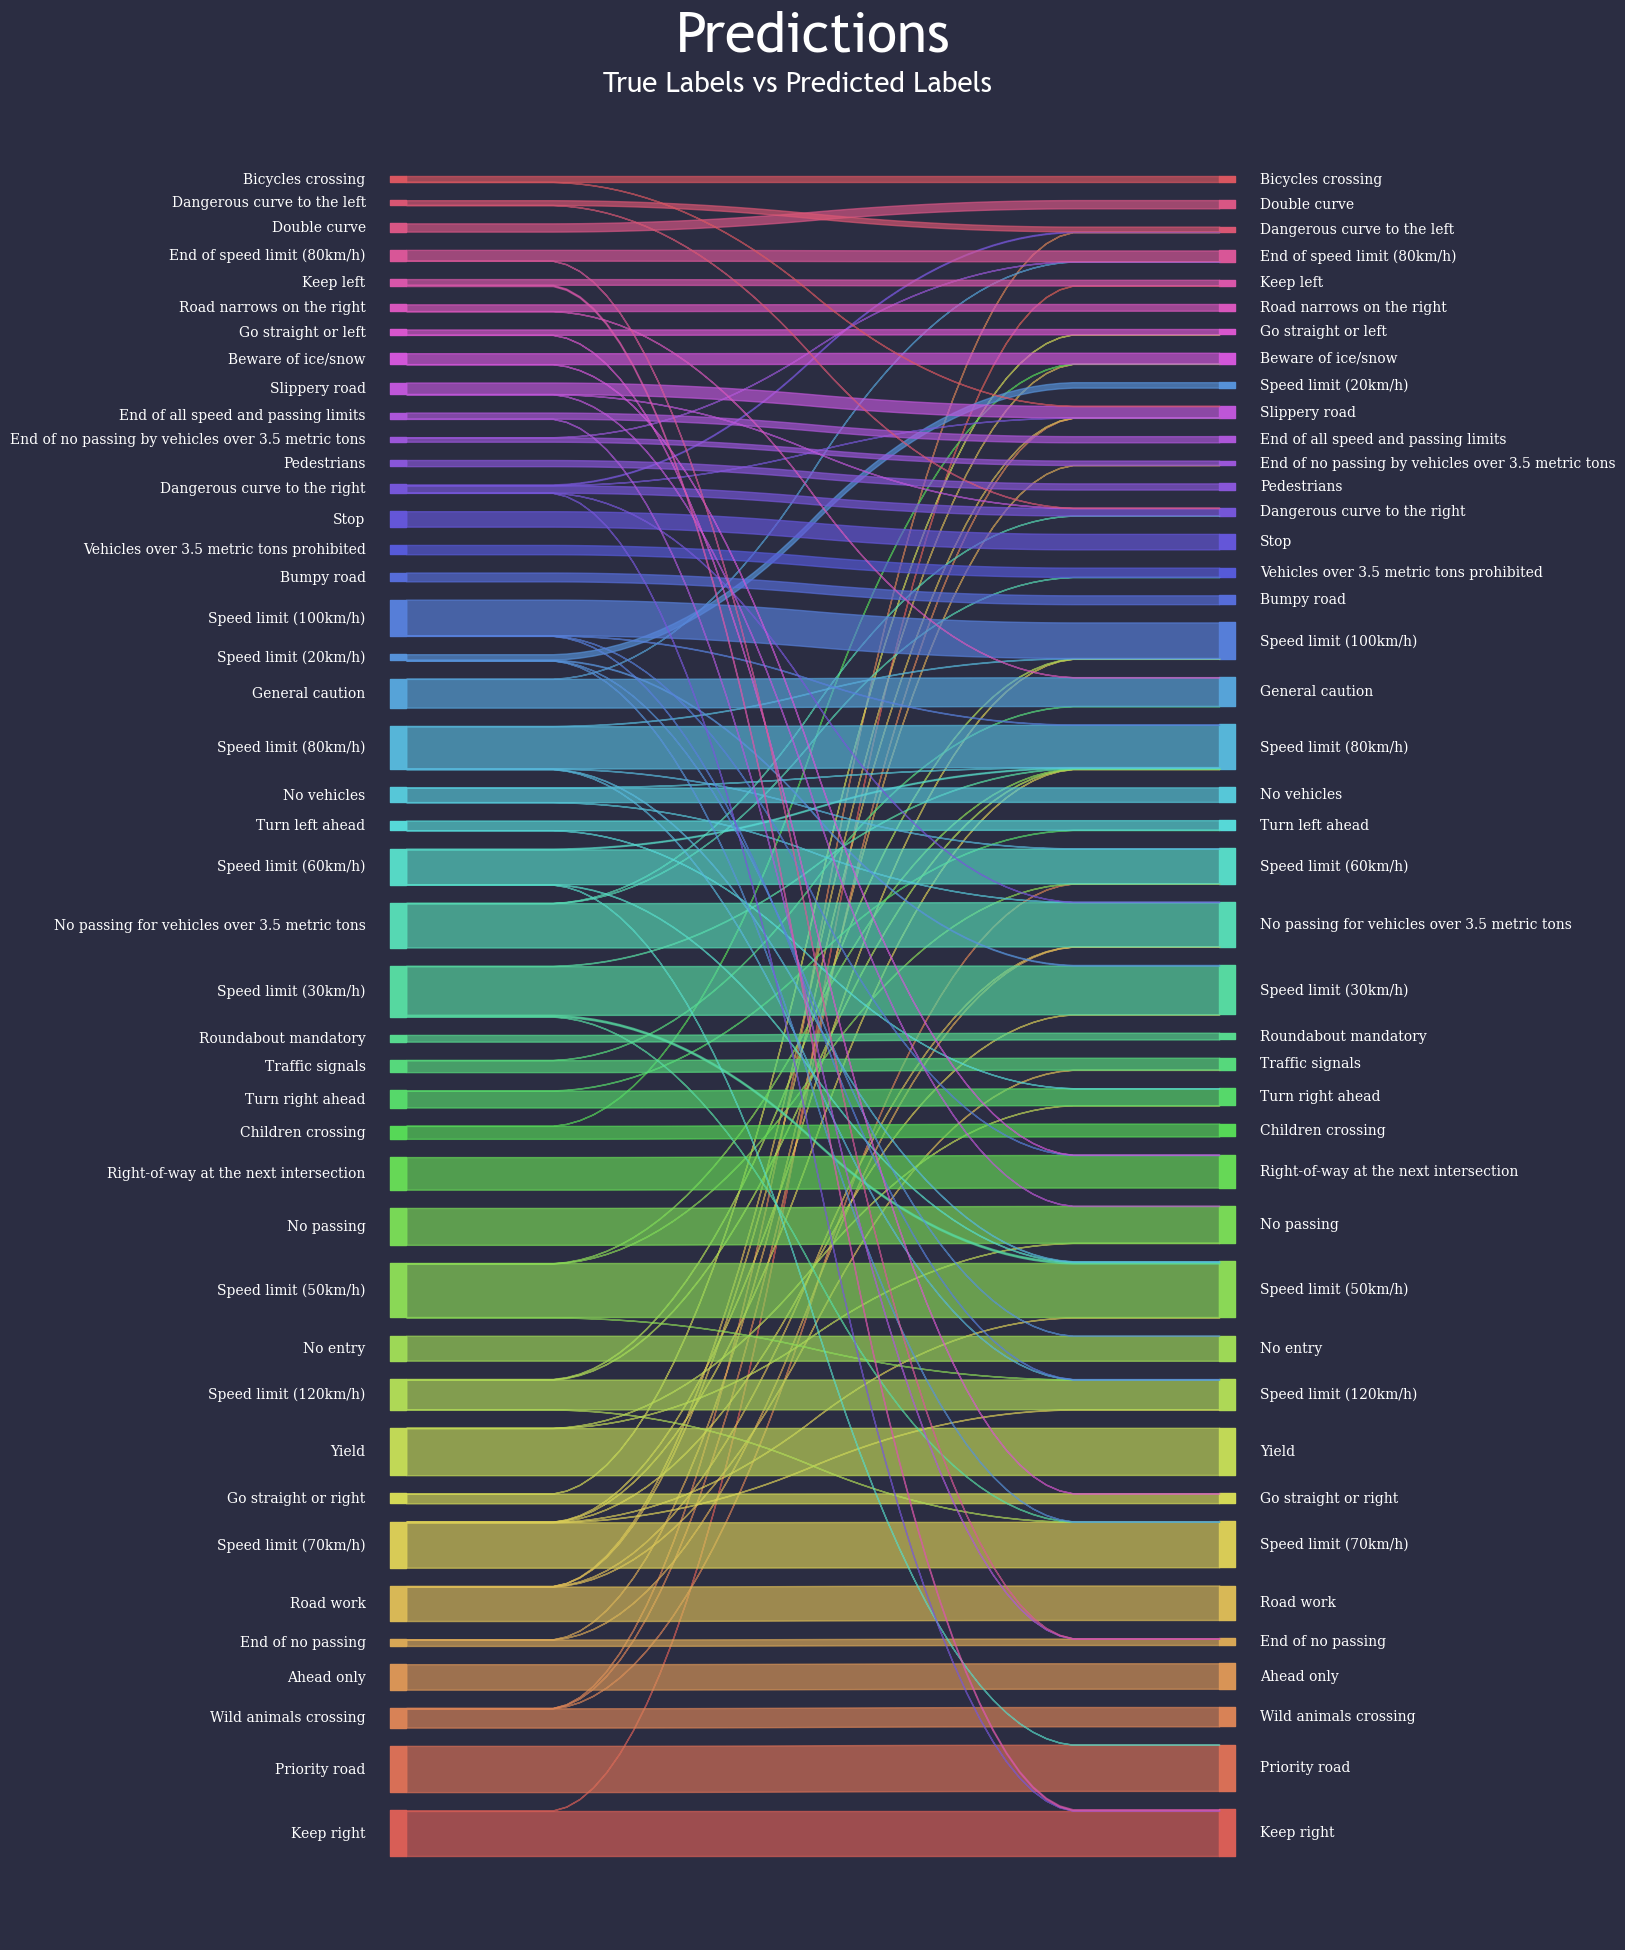

In [24]:
from pySankey.sankey import sankey
# Create a dataframe with true and predicted labels
# First, we need to get all predictions on validation set
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Create DataFrame        
Predictions_df = pd.DataFrame()
Predictions_df['True'] = true_labels
Predictions_df['Pred'] = pred_labels

# Map numeric classes to their names
Predictions_df['True'] = Predictions_df['True'].map(sign_names)
Predictions_df['Pred'] = Predictions_df['Pred'].map(sign_names)

# Generate the Sankey diagram
sankey(
    left=Predictions_df['True'], 
    right=Predictions_df['Pred'], 
    aspect=20, fontsize=10
)

# Get current figure
fig = plt.gcf()

# Set size in inches
fig.set_size_inches(12, 24)

# Set the color of the background to white
fig.set_facecolor("#2b2d42")

plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.titlecolor'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.labelsize'] = 'large'

plt.rcParams['font.family'] = 'Trebuchet MS'
plt.rcParams['font.size'] = 30

# Title
plt.title("Predictions", fontsize=40, fontname='Trebuchet MS', pad=30)
# Subtitle 
plt.suptitle("True Labels vs Predicted Labels", fontsize=20, fontname='Trebuchet MS', y=0.889)

# Save the figure
fig.savefig(results_dir + "/sankey_confusion.png", bbox_inches="tight", dpi=300)